### Imports

In [1]:

from util.data_util import *
import pandas as pd
from datetime import datetime
OPENSLIDE_PATH = "C:\\Users\\peter\\Documents\\Uni\\Second_Year\\MDP\\Openslide\\openslide-bin-4.0.0.3-windows-x64\\bin"
with os.add_dll_directory(OPENSLIDE_PATH):
        import openslide

Assuming we have locally the dataset CPTAC-PDA from
https://www.cancerimagingarchive.net/collection/cptac-pda/
And the annotations from
https://portal.gdc.cancer.gov/projects/CPTAC-3

## Preprocess the CT scans

In [4]:
root_path = os.path.normpath('./data/raw/Dataset5PatientsCPTAC/manifest-1716725357109/CPTAC-PDA')
DIRNAMES = 1
subfolders = [f.path for f in os.scandir(root_path) if f.is_dir()] #Get patients folders
target_shape = [16, 224, 224]
annotations = pd.read_csv('./data/clinical_annotations.tsv', sep='\t')
# Since the volumes are put in subfolders of patient's folders (and I'm still not sure about which of the 
# volume subfolders I should choose) I choose the first subfolder of the patient as the volume to be 
# preprocessed. 
for subfolder in subfolders:
    #Get first subfolder
    studies_folders = [f.path for f in os.scandir(subfolder) if f.is_dir()]
    first_study = studies_folders[0]
    
    nearest_clinical_trial = float('inf')
    
    volume_folder_path = ""
    #Iterate through each first volume of each study to get the study with the nearest clinical trial
    for study_folder in studies_folders:
        volumes_folders = [f.path for f in os.scandir(first_study) if f.is_dir()]
        first_volume_folder = volumes_folders[0]
        volume_trial = int(get_volume_clinicalTrialTimePoint(volume_folder))
        if volume_trial < nearest_clinical_trial:
            nearest_clinical_trial = volume_trial
            volume_folder = first_volume_folder
                
        
    
    #load the volume from patient's volume subfolder
    vol, dim = load_single_volume(first_volume_folder)
    
    #Preprocess the volume with the desired target shape
    vol = preprocess(vol, target_shape)

    #Save vol in correct subdir based on cancer grade annotation
    patient_id = subfolder.split("\\")[-1]
    cancer_grade = annotations.loc[annotations['case_submitter_id'] == patient_id]['tumor_grade'].iloc[0]
    print(cancer_grade)
    output_path = "./data/processed/CT/"+cancer_grade+"/"
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    np.save(output_path+"/"+patient_id,vol)


G2
G2
G1
G1
G2


### Get volumes that have an associated segmentation or seed point

In [2]:
root_path = os.path.normpath('./data/raw/Dataset5PatientsCPTAC/manifest-1716725357109/CPTAC-PDA')
DIRNAMES = 1
subfolders = [f.path for f in os.scandir(root_path) if f.is_dir()] #Get patients folders
target_shape = [16, 224, 224]
annotations = pd.read_csv('./data/clinical_annotations.tsv', sep='\t')
segmentations = pd.read_csv('./data/Metadata_Report_CPTAC-PDA_2023_07_14.csv')
metadata = pd.read_csv('./data/raw/Dataset5PatientsCPTAC/manifest-1716725357109/metadata.csv', sep=",")
# Since the volumes are put in subfolders of patient's folders (and I'm still not sure about which of the 
# volume subfolders I should choose) I choose the first subfolder of the patient as the volume to be 
# preprocessed. 

for subfolder in subfolders:
    #Get first subfolder
    print(subfolder)
    patient_id = subfolder.split('\\')[-1]
    series_instance_uid = segmentations.loc[segmentations["PatientID"] == patient_id]["ReferencedSeriesInstanceUID"].iloc[0]   
    
    volume_folder = metadata[metadata["Series UID"]==series_instance_uid]["File Location"].iloc[0]
    volume_folder = root_path+"\\."+volume_folder
    
    ##load the volume from patient's volume subfolder
    vol, dim = load_single_volume(volume_folder)
    
    #Preprocess the volume with the desired target shape
    vol = preprocess(vol, target_shape)

    #Save vol in correct subdir based on cancer grade annotation
    patient_id = subfolder.split("\\")[-1]
    cancer_grade = annotations.loc[annotations['case_submitter_id'] == patient_id]['tumor_grade'].iloc[0]
    print(cancer_grade)
    output_path = "./data/processed/CT/"+cancer_grade+"/"
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    np.save(output_path+"/"+patient_id,vol)

data\raw\Dataset5PatientsCPTAC\manifest-1716725357109\CPTAC-PDA\C3L-00189
G2
data\raw\Dataset5PatientsCPTAC\manifest-1716725357109\CPTAC-PDA\C3L-00401
G2
data\raw\Dataset5PatientsCPTAC\manifest-1716725357109\CPTAC-PDA\C3L-00599
G1
data\raw\Dataset5PatientsCPTAC\manifest-1716725357109\CPTAC-PDA\C3L-00622
G1
data\raw\Dataset5PatientsCPTAC\manifest-1716725357109\CPTAC-PDA\C3L-00625
G2


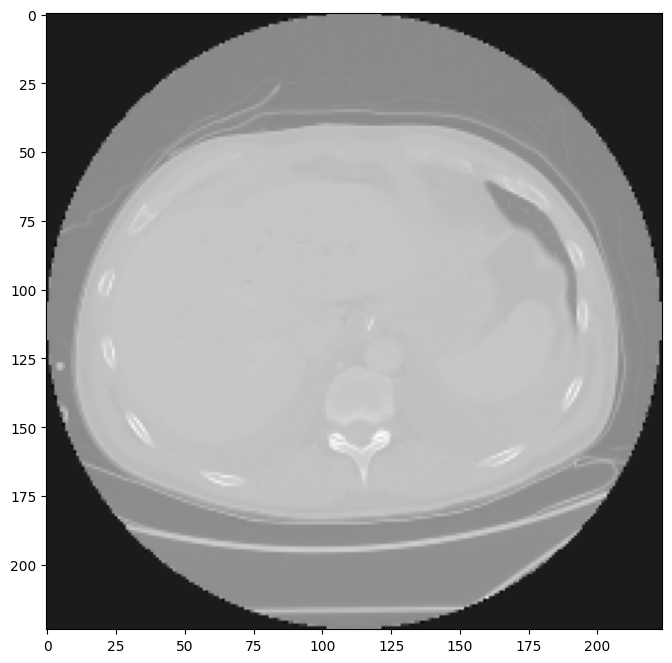

In [17]:

vol = np.load("./data/processed/CT/G1/C3L-00599.npy")
plt.figure(figsize=(8,8))
plt.imshow(vol[3,:,:], cmap='gray')

## Preprocess the WSI

In [3]:
dataset_path = os.path.normpath('./data/raw/Dataset5PatientsCPTAC/WSI/')
DIRNAMES = 1
annotations = pd.read_csv('./data/clinical_annotations.tsv', sep='\t')
wsi_ext = '.svs'
patch_size = [224,224]
threshold = 0.9 #tissue percentage per patch
max_patches = 16 #The number of patches we want per patient

#Get patients ids
patients_ids = get_patients_ids(dataset_path)
print(patients_ids)

#We get for each patient its corresponding year of diagnosis from the clinical annotations
patients_diagnosis_year = {}
for patient_id in patients_ids:
  patients_diagnosis_year[patient_id] = annotations.loc[annotations["case_submitter_id"] == patient_id]["year_of_diagnosis"].values[0]

#We create a dictionary that associates to each patient a dictionary composed of "date", "slide", "year_diff" that basically
#contains the nearest whole slide image to the diagnosis to be processed
best_wsi_dict = dict.fromkeys(patients_ids)
for path, _, files in sorted(os.walk(dataset_path)): 
    for filename in sorted(files):
      patient_id = filename.split('.')[0]
      patient_id = patient_id[:-3]
      #best_wsi_dict[patient_id]["diagnosis_year"] 
      slide = read_wsi(os.path.join(dataset_path,filename))
      
      comment = slide.properties["openslide.comment"].split("|")
      date = ""
      for x in comment:
        if "Date" in x:
          date = x.split(" = ")[1]
          date = datetime.strptime(date,'%m/%d/%y')
      
      if  best_wsi_dict[patient_id] is None or abs(date.year - int(patients_diagnosis_year[patient_id])) <= best_wsi_dict[patient_id]["year_diff"] and date > best_wsi_dict[patient_id]["date"]:
          best_wsi_dict[patient_id] = {
            "date": date,
            "slide": slide,
            "year_diff": abs(date.year - int(patients_diagnosis_year[patient_id]))
          }
print(best_wsi_dict)
#Given the selected whole slide images we preprocess them and generate the patches at level 1 since we empirically found that on average this is
#the typical level in which we calculate patches in this dataset.
for patient_id in patients_ids:
  slide = best_wsi_dict[patient_id]["slide"]
  best_patches = get_patches_at_level(slide, patch_size, threshold, max_patches, level = 1)
      
  #Save the patches in the right directory based on the cancer grade annotation
  cancer_grade = annotations.loc[annotations['case_submitter_id'] == patient_id]['tumor_grade'].iloc[0]
  output_path = './data/processed/WSI/'+cancer_grade+'/'+patient_id+'/'
  save_patches_as_numpy(best_patches, output_path, patient_id)       
      
        
      
"""
for path, _, files in sorted(os.walk(dataset_path)): 
      for filename in (sorted(files)): 
          if filename.endswith (wsi_ext):
            #Get the patient id
            patient_id = filename.split('.')[0]
            patient_id = patient_id[:-3]
            print(patient_id)
            #Search the wsi nearest to diagnosis
            
            #Load the wsi
            slide = read_wsi(os.path.join(dataset_path,filename))
            
            #Get the 16 patches from the wsi
            best_level, best_patches = find_best_level(slide, patch_size, threshold, max_patches)
            
            #Save the patches in the right directory based on the cancer grade annotation
            cancer_grade = annotations.loc[annotations['case_submitter_id'] == patient_id]['tumor_grade'].iloc[0]
            output_path = './data/processed/WSI/'+cancer_grade+'/'+patient_id+'/'
            save_patches_as_numpy(best_patches, output_path, patient_id)

"""


{'C3L-00622', 'C3L-00189', 'C3L-00401', 'C3L-00625', 'C3L-00599'}
{'C3L-00622': {'date': datetime.datetime(2017, 4, 11, 0, 0), 'slide': OpenSlide('data\\raw\\Dataset5PatientsCPTAC\\WSI\\C3L-00622-21.svs'), 'year_diff': 0}, 'C3L-00189': {'date': datetime.datetime(2017, 4, 11, 0, 0), 'slide': OpenSlide('data\\raw\\Dataset5PatientsCPTAC\\WSI\\C3L-00189-21.svs'), 'year_diff': 1}, 'C3L-00401': {'date': datetime.datetime(2016, 11, 3, 0, 0), 'slide': OpenSlide('data\\raw\\Dataset5PatientsCPTAC\\WSI\\C3L-00401-22.svs'), 'year_diff': 0}, 'C3L-00625': {'date': datetime.datetime(2017, 4, 11, 0, 0), 'slide': OpenSlide('data\\raw\\Dataset5PatientsCPTAC\\WSI\\C3L-00625-21.svs'), 'year_diff': 0}, 'C3L-00599': {'date': datetime.datetime(2017, 4, 11, 0, 0), 'slide': OpenSlide('data\\raw\\Dataset5PatientsCPTAC\\WSI\\C3L-00599-21.svs'), 'year_diff': 1}}


"\nfor path, _, files in sorted(os.walk(dataset_path)): \n      for filename in (sorted(files)): \n          if filename.endswith (wsi_ext):\n            #Get the patient id\n            patient_id = filename.split('.')[0]\n            patient_id = patient_id[:-3]\n            print(patient_id)\n            #Search the wsi nearest to diagnosis\n            \n            #Load the wsi\n            slide = read_wsi(os.path.join(dataset_path,filename))\n            \n            #Get the 16 patches from the wsi\n            best_level, best_patches = find_best_level(slide, patch_size, threshold, max_patches)\n            \n            #Save the patches in the right directory based on the cancer grade annotation\n            cancer_grade = annotations.loc[annotations['case_submitter_id'] == patient_id]['tumor_grade'].iloc[0]\n            output_path = './data/processed/WSI/'+cancer_grade+'/'+patient_id+'/'\n            save_patches_as_numpy(best_patches, output_path, patient_id)\n\n"

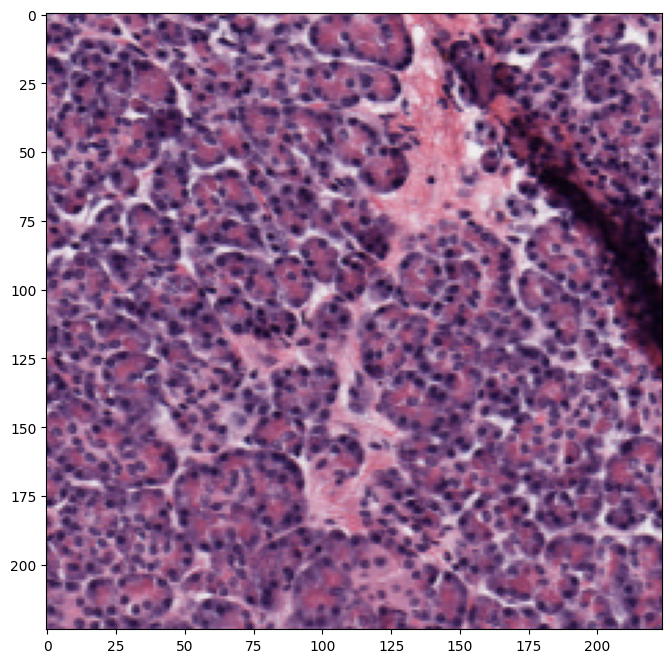

In [4]:
slide_thumb = np.load("./data/processed/WSI/G2/C3L-00625/patch_3.npy")
plt.figure(figsize=(8,8))
plt.imshow(slide_thumb)

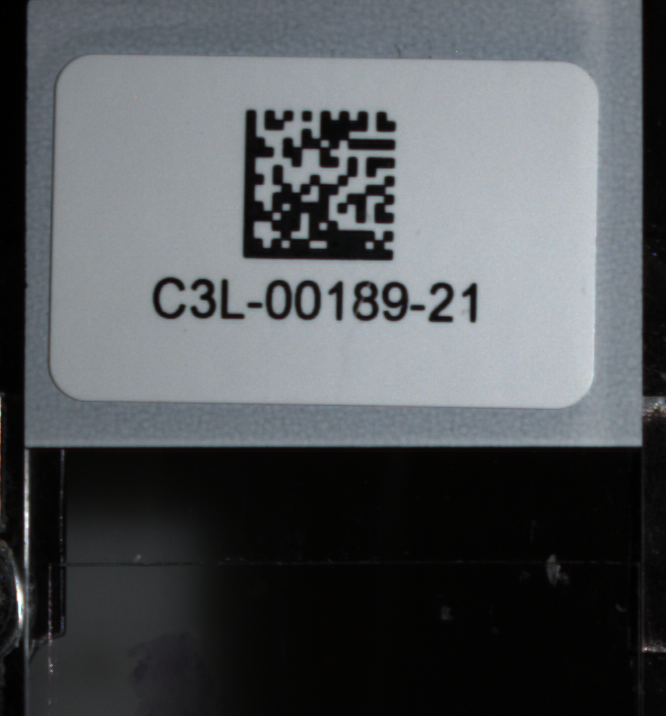

In [10]:
wsi = read_wsi("data/raw/Dataset5PatientsCPTAC/WSI/C3L-00189-21.svs")
wsi.associated_images["label"]

In [22]:
comment = wsi.properties["openslide.comment"].split("|")
date = ""
for x in comment:
    if "Date" in x:
        date = x.split(" = ")[1]
date

'04/11/17'

In [24]:
from datetime import datetime

In [25]:
date = datetime.strptime(date,'%m/%d/%y')

In [29]:
date.year

2017

In [10]:
import cptac

In [12]:
pda = cptac.Pdac()

In [13]:
ucec = cptac.Ucec()

In [16]:
ucec.list_data_sources()

,Data type,Available sources
0,CNV,"[bcm, washu]"
1,circular_RNA,[bcm]
2,miRNA,"[bcm, washu]"
3,phosphoproteomics,"[bcm, umich]"
4,proteomics,"[bcm, umich]"
5,transcriptomics,"[bcm, broad, washu]"
6,ancestry_prediction,[harmonized]
7,somatic_mutation,"[harmonized, washu]"
8,clinical,[mssm]
9,follow-up,[mssm]
